In [ ]:
!pip install numpy gym torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# SAC

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        return mean, log_std



class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class SAC:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic_optim1 = optim.Adam(self.critic1.parameters(), lr=3e-4)
        self.critic_optim2 = optim.Adam(self.critic2.parameters(), lr=3e-4)

        self.target_critic1 = Critic(state_dim, action_dim).to(device)
        self.target_critic2 = Critic(state_dim, action_dim).to(device)

        self.max_action = max_action

    def train(self, replay_buffer, iterations, batch_size=256, discount=0.99, tau=0.005, alpha=0.2):
        for it in range(iterations):
            # Sample a batch of transitions from replay buffer
            st = time.time()
            state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
            # state, action, next_state, reward = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.FloatTensor(reward).to(device)
            not_done = torch.FloatTensor(not_done).to(device)
            et = time.time()

            # print(f"Sampling time: {st - et}")

            # Update Q-functions
            st = time.time()
            with torch.no_grad():
                next_action, next_log_pi = self.actor(next_state)  # Compute next action and log probability
                target_Q = reward + discount * not_done * torch.min(
                    self.target_critic1(next_state, next_action),
                    self.target_critic2(next_state, next_action)
                ) - alpha * next_log_pi
                # target_Q = reward + discount * torch.min(
                #     self.target_critic1(next_state, next_action),
                #     self.target_critic2(next_state, next_action)
                # ) - alpha * next_log_pi
            current_Q1 = self.critic1(state, action)
            current_Q2 = self.critic2(state, action)
            et = time.time()
            # print(f"Update Q time: {st - et}")

            st = time.time()
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            self.critic_optim1.zero_grad()
            self.critic_optim2.zero_grad()
            critic_loss.backward()
            self.critic_optim1.step()
            self.critic_optim2.step()
            et = time.time()
            # print(f"Critic backprop time: {st - et}")

             # Update actor
            st = time.time()
            sampled_actions, log_pi = self.actor(state)
            min_Q = torch.min(
                self.critic1(state, sampled_actions),
                self.critic2(state, sampled_actions)
            )
            et = time.time()
            # print(f"Update actor time: {st - et}")

            st = time.time()
            actor_loss = (alpha * log_pi - min_Q).mean()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()
            et = time.time()
            # print(f"Actor backprop time: {st - et}")

            st = time.time()
            # Update target networks
            for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            et = time.time()
            # print(f"Update target time: {st - et}")

In [ ]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = map(np.stack, zip(*batch))
        return state, action, next_state, reward, done

    def __len__(self):
        return len(self.buffer)

# Training loop
def train_sac_agent(agent, env, replay_buffer, iterations):
    total_timesteps = 0
    rewards = []
    for i in tqdm(range(iterations)):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            if total_timesteps < 10000:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            total_timesteps += 1
            if len(replay_buffer) > 256:
                agent.train(replay_buffer, 256)
        rewards.append(episode_reward)
        print(f"Episode: {i+1}, Reward: {episode_reward}")
    plot_rewards(rewards)

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

In [ ]:
env = gym.make('Pendulum-v1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
replay_buffer = ReplayBuffer(1000000)

sac_agent = SAC(state_dim, action_dim, max_action)
print(sac_agent.actor, sac_agent.critic1, sac_agent.critic2)

Actor(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (mean): Linear(in_features=256, out_features=1, bias=True)
  (log_std): Linear(in_features=256, out_features=1, bias=True)
) Critic(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
) Critic(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
train_sac_agent(sac_agent, env, replay_buffer, iterations=1)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-17-96fea3098e02>:49: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)


Episode: 1, Reward: -977.8550310484451


 20%|██        | 2/10 [17:39<1:10:39, 529.94s/it]

Episode: 2, Reward: -1436.7898705758769


 20%|██        | 2/10 [19:23<1:17:35, 581.96s/it]


KeyboardInterrupt: 

# **FAC**

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        return mean, log_std

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class FAC_StatewiseLagrangian:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.max_action = max_action
        self.lagrange_multipliers = torch.zeros(action_dim).to(device)

    def compute_constraint_violations(self, state, action):
        # Implement constraint violation computation here
        # This function evaluates the feasibility constraints for the given state and action
        # Returns a tensor of constraint violations for each action dimension
        return torch.zeros_like(action)

    def update_lagrange_multipliers(self, updates):
        # Update Lagrange multipliers based on the computed updates
        self.lagrange_multipliers = torch.clamp(self.lagrange_multipliers + updates, min=0)

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            mean, log_std = self.actor(state)
            std_dev = torch.exp(log_std)
            normal = torch.distributions.Normal(mean, std_dev)
            action = normal.sample()
            action = torch.clamp(action, -self.max_action, self.max_action)
        return action.cpu()

    def train(self, replay_buffer, iterations, batch_size=256, discount=0.99, tau=0.005, alpha=0.2, zeta=0.1):
        for it in range(iterations):
            state, action, next_state, reward, _ = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Update critic
            with torch.no_grad():
                next_action = self.select_action(next_state)
                target_Q = reward + discount * self.critic(next_state, next_action)
            current_Q = self.critic(state, action)
            critic_loss = F.mse_loss(current_Q, target_Q)
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            # Update actor with constraint
            mean, log_std = self.actor(state)
            std_dev = torch.exp(log_std)
            normal = torch.distributions.Normal(mean, std_dev)
            sampled_action = normal.sample()
            sampled_action = torch.clamp(sampled_action, -self.max_action, self.max_action)

            # Compute feasibility constraint violations
            constraint_violations = self.compute_constraint_violations(state, sampled_action)

            # Compute Lagrange multiplier updates
            lagrange_multiplier_updates = zeta * constraint_violations

            # Update Lagrange multipliers
            self.update_lagrange_multipliers(lagrange_multiplier_updates)

            # Compute actor loss
            actor_loss = -torch.mean(self.critic(state, sampled_action)) + torch.sum(self.lagrange_multipliers * constraint_violations)

            # Update actor
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = map(np.stack, zip(*batch))
        return state, action, next_state, reward, done

    def __len__(self):
        return len(self.buffer)

def train_fac_agent(agent, env, replay_buffer, iterations):
    total_timesteps = 0
    rewards = []
    for i in tqdm(range(iterations)):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            total_timesteps += 1
            if len(replay_buffer) > 256:
                agent.train(replay_buffer, 256)
        rewards.append(episode_reward)
        print(f"Episode: {i+1}, Reward: {episode_reward}")
    plot_rewards(rewards)

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

fac_agent = FAC_StatewiseLagrangian(state_dim, action_dim, max_action)

replay_buffer = ReplayBuffer(1000000)
print(fac_agent.actor, fac_agent.critic)

Actor(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (mean): Linear(in_features=256, out_features=1, bias=True)
  (log_std): Linear(in_features=256, out_features=1, bias=True)
) Critic(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
train_fac_agent(fac_agent, env, replay_buffer, iterations=10)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:260: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(
 10%|█         | 1/10 [00:00<00:02,  3.56it/s]

Episode: 1, Reward: -1353.3167724609375


<ipython-input-13-357e6029a94b>:43: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q, target_Q)
 20%|██        | 2/10 [11:04<52:05, 390.70s/it]

Episode: 2, Reward: -1424.642578125


 20%|██        | 2/10 [16:19<1:05:18, 489.80s/it]


KeyboardInterrupt: 

# FAC algo with SAC Q-function

Episode: 1, Reward: -909.3823137422556


<ipython-input-6-7d7525ec1163>:86: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)


Episode: 2, Reward: -1729.7005441487486
Episode: 3, Reward: -1259.0491281145873
Episode: 4, Reward: -1241.9878466555188
Episode: 5, Reward: -1324.739112832568
Episode: 6, Reward: -1504.2532267264878
Episode: 7, Reward: -1328.9983528234359
Episode: 8, Reward: -1346.0955385677946
Episode: 9, Reward: -997.6824302233204
Episode: 10, Reward: -990.1323491693242


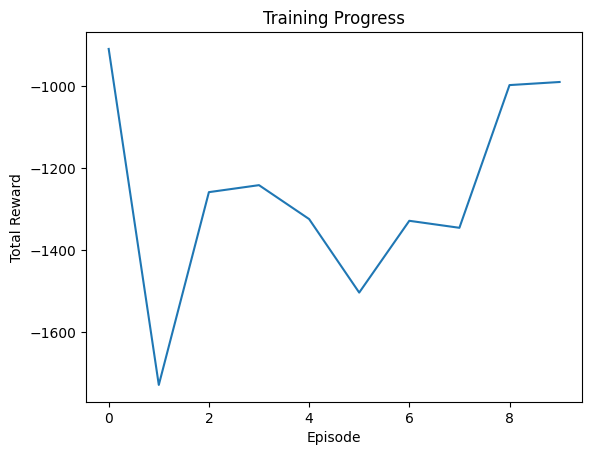

In [ ]:
# @title FAC SAC Q function
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, action_dim)
        self.std_dev = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        std_dev = F.softplus(self.std_dev(x))
        return mean, std_dev

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class FAC_StatewiseLagrangian:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)

        self.sac_q1 = Critic(state_dim, action_dim).to(device)
        self.sac_q2 = Critic(state_dim, action_dim).to(device)

        self.sac_q1_target = Critic(state_dim, action_dim).to(device)
        self.sac_q2_target = Critic(state_dim, action_dim).to(device)

        self.sac_q1_optim = optim.Adam(self.sac_q1.parameters(), lr=3e-4)
        self.sac_q2_optim = optim.Adam(self.sac_q2.parameters(), lr=3e-4)

        # Initialize target networks to match the SAC critics
        self.sac_q1_target.load_state_dict(self.sac_q1.state_dict())
        self.sac_q2_target.load_state_dict(self.sac_q2.state_dict())

        self.max_action = max_action

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            mean, std_dev = self.actor(state)
            action = torch.normal(mean, std_dev).cpu().data.numpy()
        return action

    def train(self, replay_buffer, iterations, batch_size=256, discount=0.99, actor_lr=3e-4, critic_lr=3e-4, tau=0.005):
        for it in range(iterations):
            # Sample a batch of transitions from replay buffer
            state, action, next_state, reward, _ = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Update SAC critics
            with torch.no_grad():
                next_action, next_log_pi = self.actor(next_state)
                target_Q1 = self.sac_q1_target(next_state, next_action)
                target_Q2 = self.sac_q2_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2) - 0.2 * next_log_pi
                target_Q = reward + discount * target_Q

            current_Q1 = self.sac_q1(state, action)
            current_Q2 = self.sac_q2(state, action)

            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            self.sac_q1_optim.zero_grad()
            self.sac_q2_optim.zero_grad()
            critic_loss.backward()
            self.sac_q1_optim.step()
            self.sac_q2_optim.step()

            # Update actor with constraint
            mean, std_dev = self.actor(state)
            sampled_action = torch.normal(mean, std_dev)
            updated_Q = torch.min(self.sac_q1(state, sampled_action), self.sac_q2(state, sampled_action))

            actor_loss = -torch.mean(updated_Q)

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            # Detach updated_Q after using it to compute actor_loss
            updated_Q = updated_Q.detach()

            # Update target networks
            for param, target_param in zip(self.sac_q1.parameters(), self.sac_q1_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            for param, target_param in zip(self.sac_q2.parameters(), self.sac_q2_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

fac_agent = FAC_StatewiseLagrangian(state_dim, action_dim, max_action)

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = map(np.stack, zip(*batch))
        return state, action, next_state, reward, done

    def __len__(self):
        return len(self.buffer)

def train_fac_agent(agent, env, replay_buffer, iterations):
    total_timesteps = 0
    rewards = []
    for i in range(iterations):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            total_timesteps += 1
            if len(replay_buffer) > 256:
                agent.train(replay_buffer, 256)
        rewards.append(episode_reward)
        print(f"Episode: {i+1}, Reward: {episode_reward}")
    plot_rewards(rewards)

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

replay_buffer = ReplayBuffer(1000000)

train_fac_agent(fac_agent, env, replay_buffer, iterations=10)


# SAC + Safe RL + DK

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, action_dim)
        self.std_dev = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        std_dev = F.softplus(self.std_dev(x))
        return mean, std_dev

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class FAC_CustomQ:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            mean, std_dev = self.actor(state)
            action = torch.normal(mean, std_dev).cpu().data.numpy()
        return action

    def train(self, replay_buffer, iterations, batch_size=256, discount=0.99, actor_lr=3e-4, critic_lr=3e-4, tau=0.005, alpha=0.2, zeta=0.1):
        for it in range(iterations):
            # Sample a batch of transitions from replay buffer
            state, action, next_state, reward, _ = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Update critic
            with torch.no_grad():
                next_action, next_log_pi = self.actor(next_state)
                next_Q = self.critic(next_state, next_action)
                next_entropy = -next_log_pi
                next_Q += alpha * next_entropy  # Add entropy term to Q-value

            target_Q = reward + discount * next_Q

            current_Q = self.critic(state, action)

            critic_loss = F.mse_loss(current_Q, target_Q)

            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            # Update actor with constraint
            mean, std_dev = self.actor(state)
            sampled_action = torch.normal(mean, std_dev)
            updated_Q = self.critic(state, sampled_action)
            updated_Q -= zeta * torch.log(torch.clamp(mean, 1e-6, 1.0))  # Add log-policy term to Q-value

            actor_loss = -torch.mean(updated_Q)

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = map(np.stack, zip(*batch))
        return state, action, next_state, reward, done

    def __len__(self):
        return len(self.buffer)

def train_agent(agent, env, replay_buffer, iterations):
    total_timesteps = 0
    rewards = []
    for i in tqdm(range(iterations)):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            total_timesteps += 1
            if len(replay_buffer) > 256:
                agent.train(replay_buffer, 256)
        rewards.append(episode_reward)
        print(f"Episode: {i+1}, Reward: {episode_reward}")
    plot_rewards(rewards)

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

custom_agent = FAC_CustomQ(state_dim, action_dim, max_action)

replay_buffer = ReplayBuffer(1000000)
print(custom_agent.actor, custom_agent.critic)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Actor(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (mean): Linear(in_features=64, out_features=1, bias=True)
  (std_dev): Linear(in_features=64, out_features=1, bias=True)
) Critic(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 10%|█         | 1/10 [00:00<00:01,  6.83it/s]<ipython-input-3-322d0a173b0c>:38: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q, target_Q)


Episode: 1, Reward: -1843.605940484202


 20%|██        | 2/10 [04:52<22:58, 172.28s/it]

Episode: 2, Reward: -1500.0399137158631


 30%|███       | 3/10 [11:46<32:58, 282.63s/it]

Episode: 3, Reward: -1170.151494812033


 40%|████      | 4/10 [18:52<33:54, 339.12s/it]

Episode: 4, Reward: -974.696669826238


 50%|█████     | 5/10 [25:56<30:47, 369.52s/it]

Episode: 5, Reward: -1199.4401160298892


 60%|██████    | 6/10 [33:00<25:52, 388.09s/it]

Episode: 6, Reward: -1061.4821370717643


 70%|███████   | 7/10 [40:07<20:03, 401.02s/it]

Episode: 7, Reward: -991.1273091549423


 80%|████████  | 8/10 [47:14<13:38, 409.31s/it]

Episode: 8, Reward: -1507.627707257394


 90%|█████████ | 9/10 [54:20<06:54, 414.45s/it]

Episode: 9, Reward: -1418.5156468392763


100%|██████████| 10/10 [1:01:30<00:00, 369.07s/it]

Episode: 10, Reward: -1261.60651149355


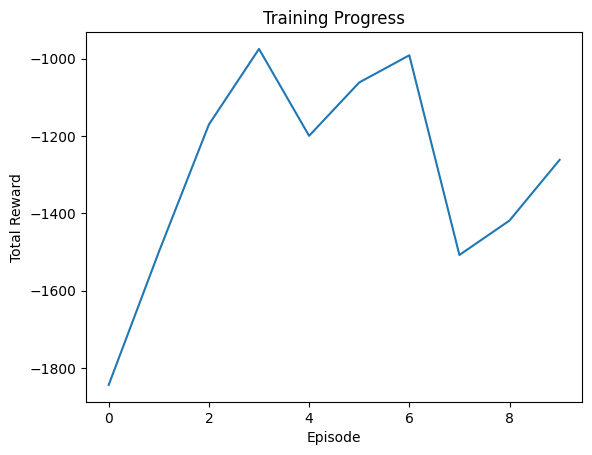

In [ ]:
train_agent(custom_agent, env, replay_buffer, iterations=10)